# Построение модели определения температуры стали

Чтобы оптимизировать производственные расходы, металлургический комбинат ООО «Так закаляем сталь» решил уменьшить потребление электроэнергии на этапе обработки стали. Нам предстоит построить модель, которая предскажет температуру стали.


###### Описание данных

Данные состоят из файлов, полученных из разных источников:

- `data_arc.csv` — данные об электродах;
- `data_bulk.csv` — данные о подаче сыпучих материалов (объём);
- `data_bulk_time.csv` *—* данные о подаче сыпучих материалов (время);
- `data_gas.csv` — данные о продувке сплава газом;
- `data_temp.csv` — результаты измерения температуры;
- `data_wire.csv` — данные о проволочных материалах (объём);
- `data_wire_time.csv` — данные о проволочных материалах (время).

## Изучение данных

Импортируем необходимые библиотеки.

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from catboost import CatBoostRegressor
import lightgbm as lgb
import xgboost as xgb
from sklearn.neighbors import KNeighborsRegressor
from sklearn.dummy import DummyRegressor

from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score

from scipy.stats import randint, uniform

import time

import datetime

RANDOM_STATE = 80822

Загрузим данные.

In [2]:
arc = pd.read_csv('/datasets/final_steel/data_arc.csv')
bulk = pd.read_csv('/datasets/final_steel/data_bulk.csv')
bulk_time = pd.read_csv('/datasets/final_steel/data_bulk_time.csv')
gas = pd.read_csv('/datasets/final_steel/data_gas.csv')
temp = pd.read_csv('/datasets/final_steel/data_temp.csv')
wire = pd.read_csv('/datasets/final_steel/data_wire.csv')
wire_time = pd.read_csv('/datasets/final_steel/data_wire_time.csv')

Напишем функцию по выводу основной информации по каждому датафрейму.

In [3]:
def gen_info(data):    
    beginning = '\033[1m' # две переменные отвечающие за жирность текста
    end = '\033[0m'
    
    print(beginning + 'Посмотрим на первые пять строк данных' + end)
    display(data.head())
    print('______________________________________________________________')
    print('')
    print(beginning + 'Посмотрим на общую информацию' + end)
    display(data.info())
    print('______________________________________________________________')
    print('')
    print(beginning + 'Посмотрим на основные статистические данные' + end)
    display(data.describe().T)
    print('______________________________________________________________')
    print('')
    print(beginning + 'Посмотрим, есть ли явные дубликаты' + end)
    display(data.duplicated().sum())

### Данные об электродах

In [4]:
gen_info(arc)

Посмотрим на первые пять строк данных


,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397


______________________________________________________________

Посмотрим на общую информацию
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


None

______________________________________________________________

Посмотрим на основные статистические данные


,count,mean,std,min,25%,50%,75%,max
key,14876.0,1615.220422,934.571502,1.000000,806.000000,1617.000000,2429.000000,3241.000000
Активная мощность,14876.0,0.670441,0.408159,0.030002,0.395297,0.555517,0.857034,3.731596
Реактивная мощность,14876.0,0.452592,5.878702,-715.504924,0.290991,0.415962,0.637371,2.676388


______________________________________________________________

Посмотрим, есть ли явные дубликаты


0

#### Вывод

В таблице 14876 строк и 5 столбцов. Пропусков в данных нет. Тип данных времени `object`. В столбце **Активная мощность** видна скошенность данных влево. В столбце **Реактивная мощность** имеется отрицательное значение. Явных дубликатов нет.

### Данные о подаче сыпучих материалов (объём)

In [5]:
gen_info(bulk)

Посмотрим на первые пять строк данных


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


______________________________________________________________

Посмотрим на общую информацию
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


None

______________________________________________________________

Посмотрим на основные статистические данные


,count,mean,std,min,25%,50%,75%,max
key,3129.0,1624.383509,933.337642,1.0,816.00,1622.0,2431.00,3241.0
Bulk 1,252.0,39.242063,18.277654,10.0,27.00,31.0,46.00,185.0
Bulk 2,22.0,253.045455,21.180578,228.0,242.00,251.5,257.75,325.0
Bulk 3,1298.0,113.879045,75.483494,6.0,58.00,97.5,152.00,454.0
Bulk 4,1014.0,104.394477,48.184126,12.0,72.00,102.0,133.00,281.0
Bulk 5,77.0,107.025974,81.790646,11.0,70.00,86.0,132.00,603.0
Bulk 6,576.0,118.925347,72.057776,17.0,69.75,100.0,157.00,503.0
Bulk 7,25.0,305.600000,191.022904,47.0,155.00,298.0,406.00,772.0
Bulk 8,1.0,49.000000,NaN,49.0,49.00,49.0,49.00,49.0
Bulk 9,19.0,76.315789,21.720581,63.0,66.00,68.0,70.50,147.0


______________________________________________________________

Посмотрим, есть ли явные дубликаты


0

#### Вывод

В таблице 3129 строк и 16 столбцов. Поскольку в партии добавляются одни компоненты, а другие нет, то пропусков в данных много. Компоненты под номером 12, 14 и 15 используются чаще всех. Компонент под номером 8 используется всего один раз. Явных дубликатов нет.

### Данные о подаче сыпучих материалов (время)

In [6]:
gen_info(bulk_time)

Посмотрим на первые пять строк данных


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:21:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:03:52,NaN,2019-05-03 11:03:52,2019-05-03 11:03:52
1,2,NaN,NaN,NaN,2019-05-03 11:46:38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:40:20,NaN,2019-05-03 11:40:20,2019-05-03 11:40:20
2,3,NaN,NaN,NaN,2019-05-03 12:31:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:09:40,NaN,2019-05-03 12:09:40,2019-05-03 12:09:40
3,4,NaN,NaN,NaN,2019-05-03 12:48:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:41:24,NaN,2019-05-03 12:41:24,2019-05-03 12:41:24
4,5,NaN,NaN,NaN,2019-05-03 13:18:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:12:56,NaN,2019-05-03 13:12:56,2019-05-03 13:12:56


______________________________________________________________

Посмотрим на общую информацию
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


None

______________________________________________________________

Посмотрим на основные статистические данные


,count,mean,std,min,25%,50%,75%,max
key,3129.0,1624.383509,933.337642,1.0,816.0,1622.0,2431.0,3241.0


______________________________________________________________

Посмотрим, есть ли явные дубликаты


0

#### Вывод

В таблице 3129 строк и 16 столбцов. При визуальном анализе можно заметить, что количество пропусков в таблице **Данные о подаче сыпучих материалов (объём)** и **Данные о подаче сыпучих материалов (время)** одинаковое, это значит что связь значений таблиц имеется. С помощью данной таблицы мы проверили **Данные о подаче сыпучих материалов (объём)** на соответствие значений пропусков, и использовать её для формирования признаков не будем. 

### Данные о продувке сплава газом

In [7]:
gen_info(gas)

Посмотрим на первые пять строк данных


,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


______________________________________________________________

Посмотрим на общую информацию
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


None

______________________________________________________________

Посмотрим на основные статистические данные


,count,mean,std,min,25%,50%,75%,max
key,3239.0,1621.861377,935.386334,1.000000,812.500000,1622.000000,2431.500000,3241.00000
Газ 1,3239.0,11.002062,6.220327,0.008399,7.043089,9.836267,13.769915,77.99504


______________________________________________________________

Посмотрим, есть ли явные дубликаты


0

#### Вывод

В таблице 3239 строк и 2 столбца. Пропусков нет. Сильных аномалий предварителньо не видно. Явных дубликтов нет.

### Результаты измерения температуры

In [8]:
gen_info(temp)

Посмотрим на первые пять строк данных


,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0


______________________________________________________________

Посмотрим на общую информацию
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           15907 non-null  int64  
 1   Время замера  15907 non-null  object 
 2   Температура   13006 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 372.9+ KB


None

______________________________________________________________

Посмотрим на основные статистические данные


,count,mean,std,min,25%,50%,75%,max
key,15907.0,1607.88087,942.212073,1.0,790.0,1618.0,2427.0,3241.0
Температура,13006.0,1591.84092,21.375851,1191.0,1581.0,1591.0,1601.0,1705.0


______________________________________________________________

Посмотрим, есть ли явные дубликаты


0

#### Вывод

В таблице 15907 строк и 3 столбца. Есть пропуски в столбце температуры. Минимальная температура меньше температуры плавления стали, что должно явно настараживать. Явных дубликатов нет.

### Данные о проволочных материалах (объём)

In [9]:
gen_info(wire)

Посмотрим на первые пять строк данных


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


______________________________________________________________

Посмотрим на общую информацию
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


None

______________________________________________________________

Посмотрим на основные статистические данные


,count,mean,std,min,25%,50%,75%,max
key,3081.0,1623.426485,932.996726,1.000000,823.000000,1619.000000,2434.000000,3241.000000
Wire 1,3055.0,100.895853,42.012518,1.918800,72.115684,100.158234,126.060483,330.314424
Wire 2,1079.0,50.577323,39.320216,0.030160,20.193680,40.142956,70.227558,282.780152
Wire 3,63.0,189.482681,99.513444,0.144144,95.135044,235.194977,276.252014,385.008668
Wire 4,14.0,57.442841,28.824667,24.148801,40.807002,45.234282,76.124619,113.231044
Wire 5,1.0,15.132000,NaN,15.132000,15.132000,15.132000,15.132000,15.132000
Wire 6,73.0,48.016974,33.919845,0.034320,25.053600,42.076324,64.212723,180.454575
Wire 7,11.0,10.039007,8.610584,0.234208,6.762756,9.017009,11.886057,32.847674
Wire 8,19.0,53.625193,16.881728,45.076721,46.094879,46.279999,48.089603,102.762401
Wire 9,29.0,34.155752,19.931616,4.622800,22.058401,30.066399,43.862003,90.053604


______________________________________________________________

Посмотрим, есть ли явные дубликаты


0

#### Вывод

В таблице 3081 строк и 10 столбцов. Во всех столбцах, кроме `key` имеются пропуски. Чаще всего используются проволки под номером 1 и 2. Проволка под номером 5 использовалась всего один раз. Явных дубликатов нет.

### Данные о проволочных материалах (время)

In [10]:
gen_info(wire_time)

Посмотрим на первые пять строк данных


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:11:41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:46:10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:13:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:48:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:18:15,2019-05-03 13:32:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN


______________________________________________________________

Посмотрим на общую информацию
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


None

______________________________________________________________

Посмотрим на основные статистические данные


,count,mean,std,min,25%,50%,75%,max
key,3081.0,1623.426485,932.996726,1.0,823.0,1619.0,2434.0,3241.0


______________________________________________________________

Посмотрим, есть ли явные дубликаты


0

#### Вывод

В таблице 3081 строк и 10 столбцов. При визуальном анализе можно заметить, что количество пропусков в таблице **Данные о проволочных материалах (объем)** и **Данные о проволочных материалах (время)** одинаковое, это значит что связь значений таблиц имеется.  С помощью данной таблицы мы проверили **Данные о проволочных материалах (объем)** на соответствие значений пропусков, и использовать её для формирования признаков не будем. 

## Исследовательский анализ данных

Напишем функцию для построения тепловой карты корреляции.

In [11]:
def corr_map(data):
    # создадим половину тепловой карты корреляции
    inverted = np.triu(data.drop('key', axis=1).corr()) 

    fig = plt.subplots(figsize=(12, 8))
    sns.heatmap(data.drop('key', axis=1).corr(), vmin = -1, vmax = +1, annot = True, cmap = 'coolwarm', 
                mask = inverted)

Посмотрим на зависимость активной и реактивной мощности.

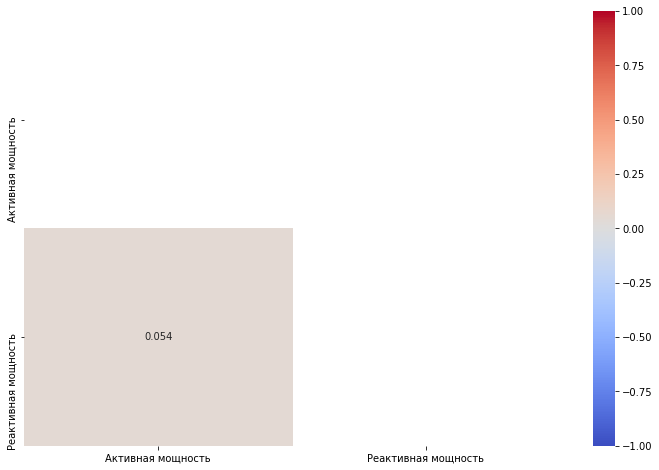

In [12]:
corr_map(arc)

Зависимость слабая, значит можно взять все три столбца в конечную таблицу признаков.

Посмотрим на количество отрицательных значений реактивной мощности.

In [13]:
arc[arc['Реактивная мощность'] < 0].count()

key                     1
Начало нагрева дугой    1
Конец нагрева дугой     1
Активная мощность       1
Реактивная мощность     1
dtype: int64

Поскольку только одно значение отрицательное, то можно просто удалить это значение.

Посмотрим на зависимость атрибутов сыпучих материалов.

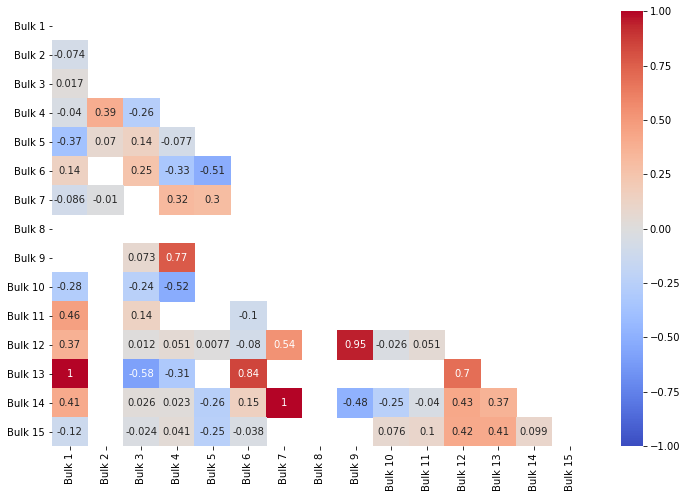

In [14]:
corr_map(bulk)

Из-за большой корреляции между атрибуами оставим в конечной таблице признаков все атрибуты, кроме **Bulk 7**, **Bulk 9**, **Bulk 13**.

Построим распределение сыпучих материалов.

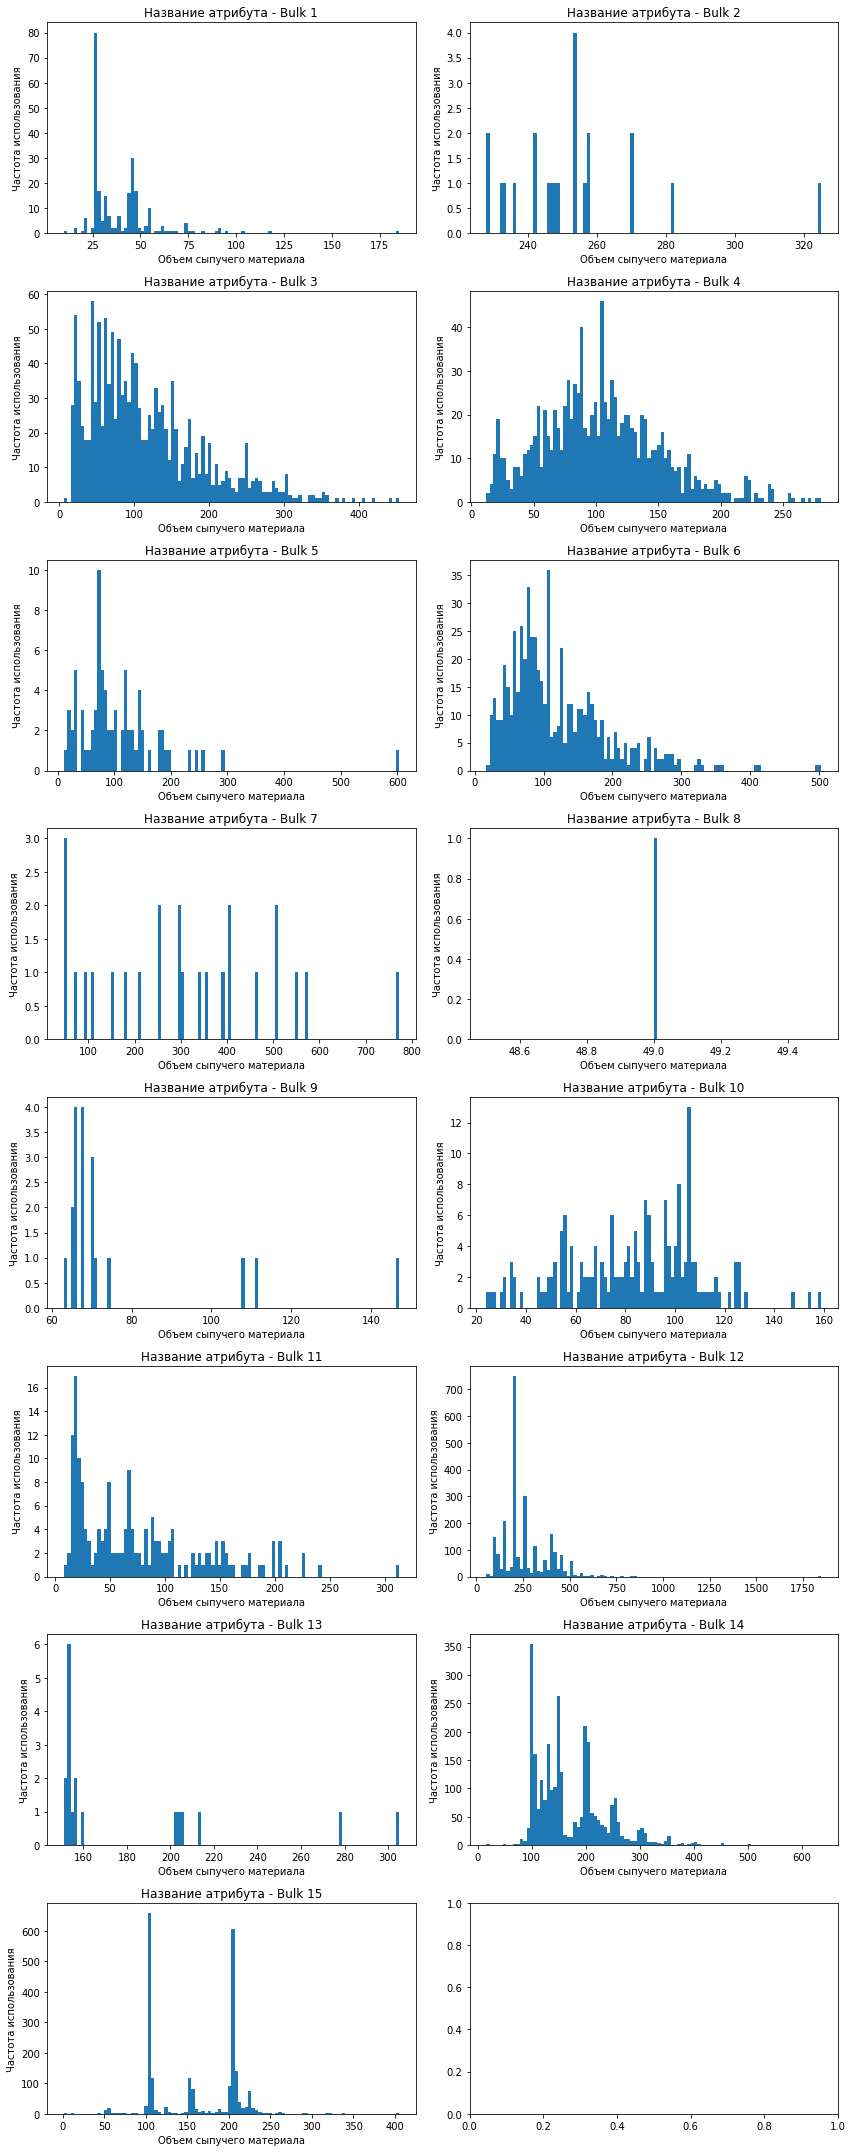

In [15]:
i, j = 0, 0
n_cols = 2
fig, axs = plt.subplots(8, 2, figsize=(12, 30), tight_layout=True)

for col in bulk.drop(['key'], axis=1).columns:
    axs[i][j].hist(bulk[col], bins=100)  
    axs[i][j].set_title(f'Название атрибута - {col}')
    axs[i][j].set_xlabel('Объем сыпучего материала')
    axs[i][j].set_ylabel('Частота использования')
    
    j += 1
    
    if j%n_cols == 0:
        i+=1
        j=0
        
plt.show()

Данные всех атрибутов, кроме **Bulk 8** и **Bulk 15** скошены влево. У компонента 8 только одно наблюдение. Частоиспользуемый компонент под номером 15 имеет бимодальное распределение. 

Построим гистограмму продувки сплава газом.

Text(0, 0.5, 'Частота')

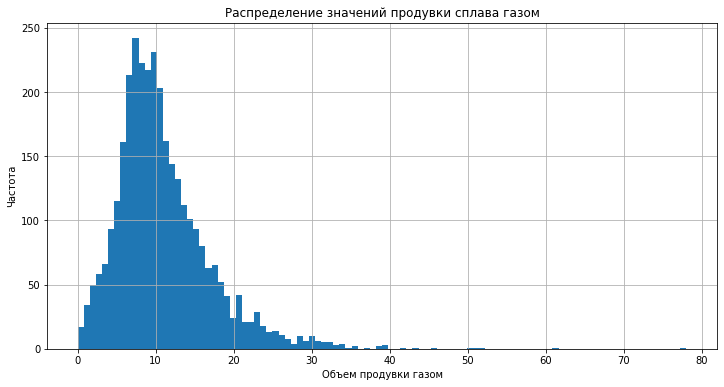

In [16]:
gas['Газ 1'].plot(kind='hist', bins=100, figsize=(12, 6), grid=True)

plt.title('Распределение значений продувки сплава газом')
plt.xlabel('Объем продувки газом')
plt.ylabel('Частота')

Данные скошенны влево. Часто используемый объем продувки от 7 до 11. При проверке, вне данной тетради, больших объемов значений выявилось, что  причина тому добавление большого количества легирующих добавок.

Теперь посмотрим на распределение температуры сплава.

Text(0, 0.5, 'Частота')

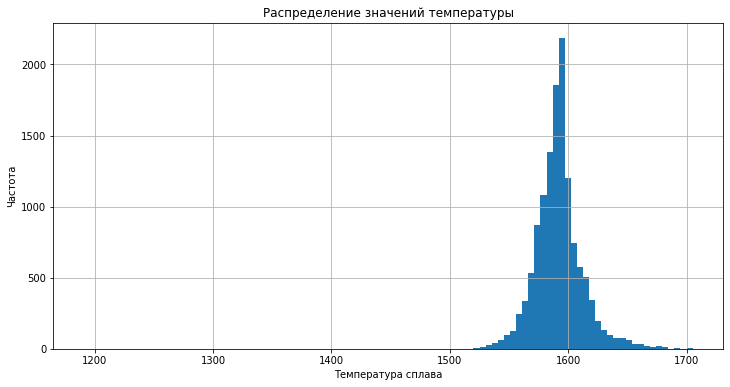

In [17]:
temp['Температура'].plot(kind='hist', bins=100, figsize=(12, 6), grid=True)

plt.title('Распределение значений температуры')
plt.xlabel('Температура сплава')
plt.ylabel('Частота')

Самая частая величина температуры в районе 1590 градусов. Видно, что есть значения температуры меньше температуры плавления стали. 

Посчитаем количество значений температуры меньше 1500 (температура плавления стали).

In [18]:
temp[temp['Температура'] < 1500]

,key,Время замера,Температура
4350,867,2019-06-04 14:21:00,1191.0
5978,1214,2019-06-16 05:32:00,1208.0
7958,1619,2019-06-30 11:03:54,1218.0
8913,1818,2019-07-07 00:30:49,1383.0
8914,1818,2019-07-07 00:31:40,1383.0
10127,2052,2019-07-21 14:51:40,1227.0
12564,2561,2019-08-08 07:34:15,1204.0


Таких значений всего 7. В дальнейшем исключим их из набора.

Посмотрим на зависимость атрибутов проволочных материалов.

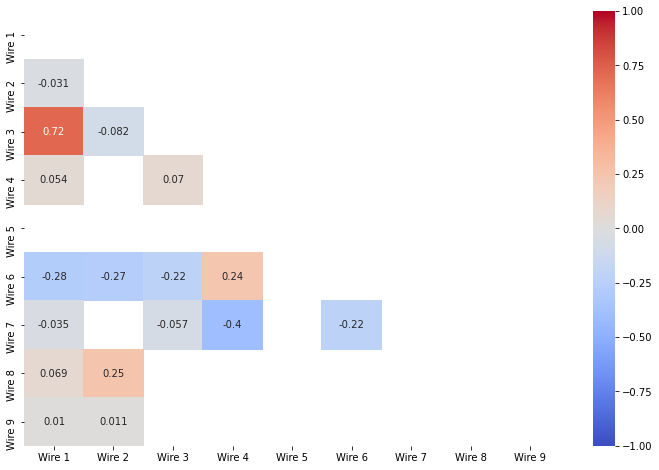

In [19]:
corr_map(wire)

В конечную таблицу признаков войдут все атрибуты, кроме **Wire 3** и **Wire 5**.

Построим распределение проволочных материалов.

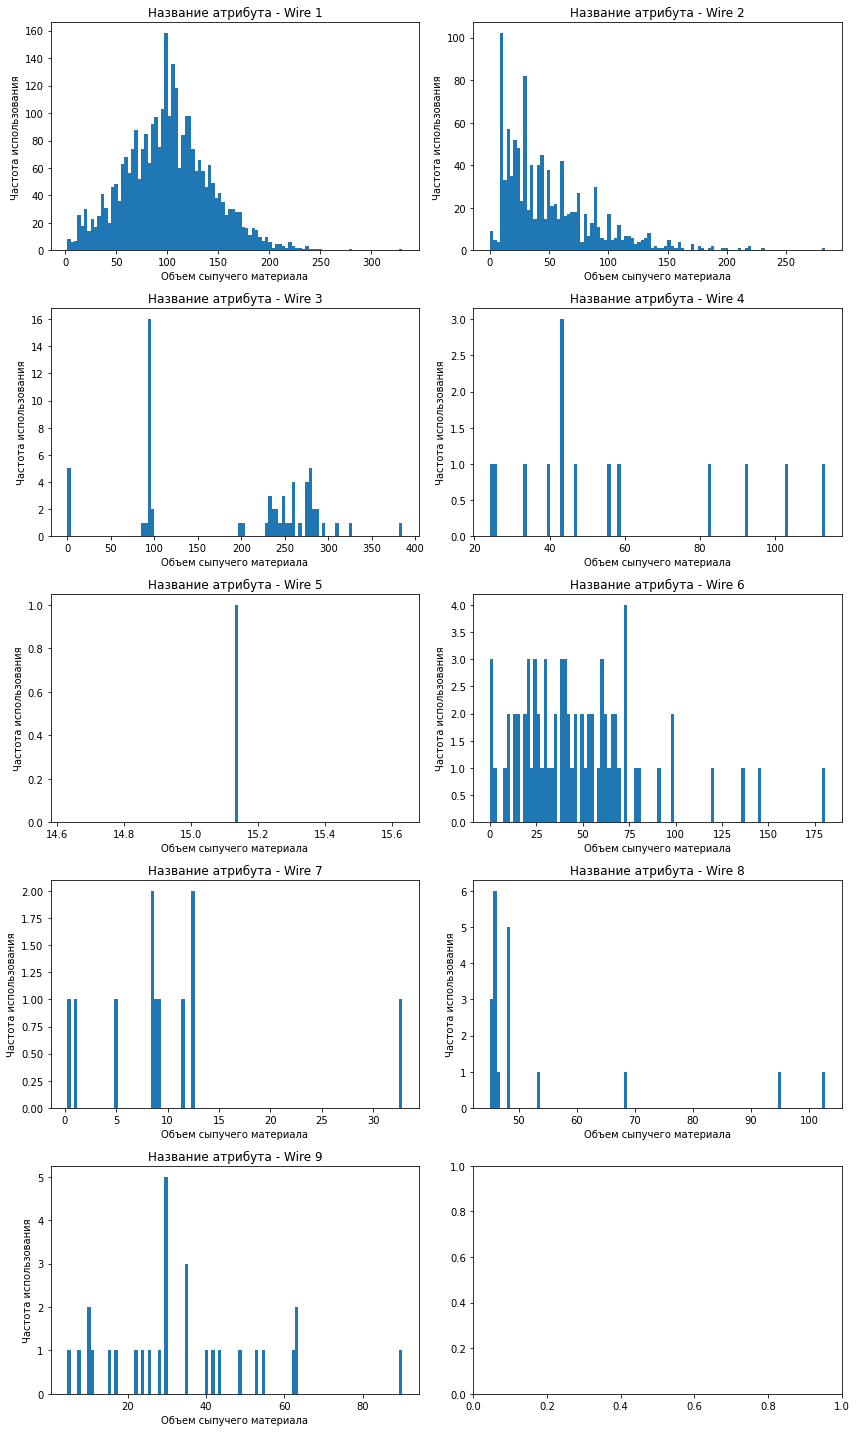

In [20]:
i, j = 0, 0
n_cols = 2
fig, axs = plt.subplots(5, 2, figsize=(12, 20), tight_layout=True)

for col in wire.drop(['key'], axis=1).columns:
    axs[i][j].hist(wire[col], bins=100)  
    axs[i][j].set_title(f'Название атрибута - {col}')
    axs[i][j].set_xlabel('Объем сыпучего материала')
    axs[i][j].set_ylabel('Частота использования')
    
    j += 1
    
    if j%n_cols == 0:
        i+=1
        j=0
        
plt.show()

У компонентов 1-2, 4, 6-9 распределения данных скошенно влево. У **Wire 3** наблюдается бимодальное распределение. Компонент **Wire 5** имеет всего одно наблюдение. 

### Вывод

При анализе данных обнаружили отрицательные значения реактивной мощности, которые необходимо удалить. Значения температуры сплава, которые ниже температуры плавления стали также необходимо исключить. Исходя из тепловой карты корреляции из таблицы по электродам в итоговую таблицу войдут **Реактивная и Активная мощности**. Из таблицы сыпучие материалы все атрибуты, кроме - **Bulk 7**, **Bulk 8**, **Bulk 9**, **Bulk 13**. А из таблицы проволочные материалы все атрибуты, кроме - **Wire 3** и **Wire 5**. При предобработке данных учтем все вышеперечисленные аномалии.

## Предобработка данных

### Удаление данных

Удалим отрицательные значения реактивной мощности.

In [21]:
arc[arc['Реактивная мощность']<0]

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
9780,2116,2019-07-24 00:44:48,2019-07-24 00:46:37,0.495782,-715.504924


In [22]:
arc = arc.drop(index = arc[arc['key'] == 2116].index)

In [23]:
arc.describe()

,key,Активная мощность,Реактивная мощность
count,14872.000000,14872.000000,14872.000000
mean,1615.085732,0.670497,0.500763
std,934.661090,0.408195,0.310897
min,1.000000,0.030002,0.020806
25%,806.000000,0.395297,0.291008
50%,1616.000000,0.555588,0.416280
75%,2429.000000,0.857121,0.637476
max,3241.000000,3.731596,2.676388


Отрицательное значение удалили.

### Генерация признаков, формирование таблицы признаков

Изменим тип данных времени сразу для всех таблиц.

In [24]:
arc['Начало нагрева дугой'] = pd.to_datetime(arc['Начало нагрева дугой'], format='%Y-%m-%d %H:%M:%S')
arc['Конец нагрева дугой'] = pd.to_datetime(arc['Конец нагрева дугой'], format='%Y-%m-%d %H:%M:%S')
temp['Время замера'] = pd.to_datetime(temp['Время замера'], format='%Y-%m-%d %H:%M:%S')

Создадим две сводные таблицы минимального и максимального значения времени замера.

In [25]:
temp_time_1 = (pd.pivot_table(temp, index=['key'], values=['Время замера'], aggfunc=['min']).
               droplevel(0, axis=1).rename_axis(None, axis=1).reset_index())
temp_time_2 = (pd.pivot_table(temp, index=['key'], values=['Время замера'], aggfunc=['max']).
               droplevel(0, axis=1).rename_axis(None, axis=1).reset_index())

Соединим по ключу время замера и температуру.

In [26]:
temp_time_1 = (temp_time_1.merge(temp.drop(['key'], axis=1), how='left', left_on='Время замера', 
                                 right_on='Время замера'))
temp_time_2 = (temp_time_2.merge(temp.drop(['key'], axis=1), how='left', left_on='Время замера', 
                                 right_on='Время замера'))

Объединим две получившиеся таблицы с максимальным и минимальным временем замера и соответсвующие им температуры.

In [27]:
temp_merge = temp_time_1.merge(temp_time_2, left_on='key', right_on='key').dropna()

Добавим новый признак общее время замера.

In [28]:
temp_merge['Measure_time'] = temp_merge['Время замера_y'] - temp_merge['Время замера_x']
temp_merge.head()

,key,Время замера_x,Температура_x,Время замера_y,Температура_y,Measure_time
0,1,2019-05-03 11:16:18,1571.0,2019-05-03 11:30:39,1613.0,0 days 00:14:21
1,2,2019-05-03 11:37:27,1581.0,2019-05-03 11:59:12,1602.0,0 days 00:21:45
2,3,2019-05-03 12:13:17,1596.0,2019-05-03 12:34:57,1599.0,0 days 00:21:40
3,4,2019-05-03 12:52:57,1601.0,2019-05-03 12:59:25,1625.0,0 days 00:06:28
4,5,2019-05-03 13:23:19,1576.0,2019-05-03 13:36:01,1602.0,0 days 00:12:42


Удалим из таблицы время замера.

In [29]:
temp_merge = temp_merge.drop(['Время замера_x', 'Время замера_y'], axis=1)

Удалим значения температур, которые ниже 1500 градусов.

In [30]:
temp_merge = temp_merge.drop(index = temp_merge[temp_merge['Температура_x'] < 1500].index)

Выведем получившуюся таблицу.

In [31]:
temp_merge.head()

,key,Температура_x,Температура_y,Measure_time
0,1,1571.0,1613.0,0 days 00:14:21
1,2,1581.0,1602.0,0 days 00:21:45
2,3,1596.0,1599.0,0 days 00:21:40
3,4,1601.0,1625.0,0 days 00:06:28
4,5,1576.0,1602.0,0 days 00:12:42


In [32]:
temp_merge.describe()

,key,Температура_x,Температура_y,Measure_time
count,2473.000000,2473.000000,2473.000000,2473
mean,1249.664375,1589.016175,1595.338051,0 days 00:30:53.312980186
std,720.395663,24.996127,16.031388,0 days 00:21:42.646929353
min,1.000000,1519.000000,1541.000000,0 days 00:00:00
25%,627.000000,1572.000000,1587.000000,0 days 00:19:41
50%,1251.000000,1588.000000,1593.000000,0 days 00:26:30
75%,1872.000000,1605.000000,1599.000000,0 days 00:37:42
max,2499.000000,1679.000000,1700.000000,0 days 06:32:17


Минимальное значение температуры больше 1500, все в порядке.

Создадим таблицу с признаками для электродов.

Добавим новый признак - время нагрева.

In [33]:
arc['Heating_time'] =  arc['Конец нагрева дугой'] - arc['Начало нагрева дугой']

Также добавим новый признак - полную мощность.

In [34]:
arc['Full_power'] =  (arc['Активная мощность']**2 + arc['Реактивная мощность']**2)**0.5

Выведем получившуюся таблицу.

In [35]:
arc.head()

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,Heating_time,Full_power
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084,0 days 00:03:48,1.193639
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285,0 days 00:03:05,0.959010
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805,0 days 00:02:52,0.896038
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669,0 days 00:06:05,1.970470
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397,0 days 00:02:28,0.807239


Посчитаем количество итераций для каждой партии.

In [36]:
arc_count_iter = pd.pivot_table(arc, index='key', values='Начало нагрева дугой', aggfunc='count').reset_index().rename(columns={'Начало нагрева дугой': 'Iteration'})

Усредним данные активной мощности, реактивной мощности и полной мощности для каждой партии.

In [37]:
arc_mean = (pd.pivot_table(arc, index='key', values=['Активная мощность', 'Реактивная мощность', 'Full_power'], 
                           aggfunc='mean').reset_index())

Посчитаем сумму времени нагрева.

In [38]:
arc_time = pd.pivot_table(arc, index='key', values=['Heating_time'], aggfunc='sum').reset_index()

Объединим все раннее созданные таблицы.

In [39]:
arc_merge = arc_time.merge(arc_mean, left_on='key', right_on='key').merge(arc_count_iter, left_on='key', right_on='key')

Выведем объединенную таблицу.

In [40]:
arc_merge.head()

,key,Heating_time,Full_power,Активная мощность,Реактивная мощность,Iteration
0,1,0 days 00:18:18,1.165279,0.975629,0.636648,5
1,2,0 days 00:13:31,0.912304,0.763150,0.499528,4
2,3,0 days 00:10:55,0.597907,0.505176,0.319815,5
3,4,0 days 00:12:21,0.953741,0.802313,0.515074,4
4,5,0 days 00:14:29,1.008939,0.836793,0.563161,4


Объединим созданные таблицы температуры и электродов с таблицами сыпучих материалов, проволочных материалов и продувки сплава газом.

In [41]:
final_table = (temp_merge.merge(arc_merge, how='inner', left_on='key', right_on='key').merge(gas, how='inner', left_on='key', right_on='key').
               merge(bulk.drop(['Bulk 7', 'Bulk 8', 'Bulk 9', 'Bulk 13'], axis=1) , how='inner', left_on='key', right_on='key').
               merge(wire.drop(['Wire 3', 'Wire 5'], axis=1), how='inner', left_on='key', right_on='key'))

Поменяем названия признаков с русского на английский.

In [42]:
final_table = (final_table.rename(columns={'Температура_x': 'Start_temp', 'Температура_y': 'Finish_temp', 
                             'Активная мощность': 'Active_power', 'Реактивная мощность': 'Reactive_power', 
                             'Газ 1': 'Gas'}).reset_index(drop=True))

Выведем итоговую таблицу признаков.

In [43]:
final_table.head()

,key,Start_temp,Finish_temp,Measure_time,Heating_time,Full_power,Active_power,Reactive_power,Iteration,Gas,...,Bulk 12,Bulk 14,Bulk 15,Wire 1,Wire 2,Wire 4,Wire 6,Wire 7,Wire 8,Wire 9
0,1,1571.0,1613.0,0 days 00:14:21,0 days 00:18:18,1.165279,0.975629,0.636648,5,29.749986,...,206.0,150.0,154.0,60.059998,NaN,NaN,NaN,NaN,NaN,NaN
1,2,1581.0,1602.0,0 days 00:21:45,0 days 00:13:31,0.912304,0.763150,0.499528,4,12.555561,...,206.0,149.0,154.0,96.052315,NaN,NaN,NaN,NaN,NaN,NaN
2,3,1596.0,1599.0,0 days 00:21:40,0 days 00:10:55,0.597907,0.505176,0.319815,5,28.554793,...,205.0,152.0,153.0,91.160157,NaN,NaN,NaN,NaN,NaN,NaN
3,4,1601.0,1625.0,0 days 00:06:28,0 days 00:12:21,0.953741,0.802313,0.515074,4,18.841219,...,207.0,153.0,154.0,89.063515,NaN,NaN,NaN,NaN,NaN,NaN
4,5,1576.0,1602.0,0 days 00:12:42,0 days 00:14:29,1.008939,0.836793,0.563161,4,5.413692,...,203.0,151.0,152.0,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN


In [44]:
final_table.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2324 entries, 0 to 2323
Data columns (total 28 columns):
 #   Column          Non-Null Count  Dtype          
---  ------          --------------  -----          
 0   key             2324 non-null   int64          
 1   Start_temp      2324 non-null   float64        
 2   Finish_temp     2324 non-null   float64        
 3   Measure_time    2324 non-null   timedelta64[ns]
 4   Heating_time    2324 non-null   timedelta64[ns]
 5   Full_power      2324 non-null   float64        
 6   Active_power    2324 non-null   float64        
 7   Reactive_power  2324 non-null   float64        
 8   Iteration       2324 non-null   int64          
 9   Gas             2324 non-null   float64        
 10  Bulk 1          199 non-null    float64        
 11  Bulk 2          13 non-null     float64        
 12  Bulk 3          958 non-null    float64        
 13  Bulk 4          811 non-null    float64        
 14  Bulk 5          53 non-null     float64 

In [45]:
final_table.describe()

,key,Start_temp,Finish_temp,Measure_time,Heating_time,Full_power,Active_power,Reactive_power,Iteration,Gas,...,Bulk 12,Bulk 14,Bulk 15,Wire 1,Wire 2,Wire 4,Wire 6,Wire 7,Wire 8,Wire 9
count,2324.000000,2324.000000,2324.000000,2324,2324,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,...,1809.000000,2064.000000,1696.000000,2301.000000,809.000000,12.000000,45.000000,4.000000,13.000000,24.000000
mean,1251.140275,1587.368761,1593.372633,0 days 00:31:39.199655765,0 days 00:13:28.196643717,0.837075,0.669399,0.499558,4.696644,11.378854,...,267.982863,173.345930,164.541274,103.447694,50.597164,59.496235,50.659374,3.703414,55.772561,30.773167
std,715.027927,23.627590,11.207457,0 days 00:22:03.253342753,0 days 00:05:40.813827565,0.242384,0.196982,0.147402,1.606210,6.397008,...,125.667744,64.028044,50.015721,42.530219,39.800935,30.804638,37.743040,3.818433,20.235591,15.210141
min,1.000000,1519.000000,1541.000000,0 days 00:03:54,0 days 00:00:57,0.228541,0.186226,0.130062,1.000000,0.008399,...,53.000000,29.000000,1.000000,1.918800,0.030160,24.148801,0.137280,0.234208,45.076721,4.622800
25%,628.750000,1571.000000,1587.000000,0 days 00:20:15,0 days 00:09:41,0.660508,0.526662,0.392669,4.000000,7.282534,...,204.000000,123.000000,105.000000,75.042236,20.180161,38.347402,25.053600,0.849004,46.002319,20.802601
50%,1254.500000,1587.000000,1593.000000,0 days 00:27:14.500000,0 days 00:12:58,0.816478,0.645157,0.488079,5.000000,10.100687,...,208.000000,153.000000,200.000000,102.036476,40.112801,49.661561,40.085762,3.044704,46.187439,30.066399
75%,1867.250000,1603.000000,1598.000000,0 days 00:38:13.250000,0 days 00:16:33,0.986702,0.792148,0.592599,6.000000,14.218487,...,360.000000,208.000000,205.000000,128.185211,70.061684,84.755579,65.036400,5.899114,46.279999,40.495001
max,2499.000000,1660.000000,1653.000000,0 days 06:32:17,0 days 01:09:49,1.796257,1.421416,1.134983,16.000000,77.995040,...,1849.000000,636.000000,405.000000,330.314424,282.780152,113.231044,180.454575,8.490040,102.762401,62.025600


Посчитаем количество секунд замеров и времени нагрева.

In [46]:
for i in range(len(final_table)):
    final_table['Measure_time'][i] = final_table['Measure_time'][i].total_seconds()
    final_table['Heating_time'][i] = final_table['Heating_time'][i].total_seconds()

/tmp/ipykernel_49/1598542350.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_table['Measure_time'][i] = final_table['Measure_time'][i].total_seconds()
/tmp/ipykernel_49/1598542350.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_table['Heating_time'][i] = final_table['Heating_time'][i].total_seconds()


Поменяем тип данных.

In [47]:
final_table['Measure_time'] = final_table['Measure_time'].astype(float)
final_table['Heating_time'] = final_table['Heating_time'].astype(float)

Заполним пропущенные значения нулем.

In [48]:
final_table = final_table.fillna(0)

In [49]:
final_table.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2324 entries, 0 to 2323
Data columns (total 28 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   key             2324 non-null   int64  
 1   Start_temp      2324 non-null   float64
 2   Finish_temp     2324 non-null   float64
 3   Measure_time    2324 non-null   float64
 4   Heating_time    2324 non-null   float64
 5   Full_power      2324 non-null   float64
 6   Active_power    2324 non-null   float64
 7   Reactive_power  2324 non-null   float64
 8   Iteration       2324 non-null   int64  
 9   Gas             2324 non-null   float64
 10  Bulk 1          2324 non-null   float64
 11  Bulk 2          2324 non-null   float64
 12  Bulk 3          2324 non-null   float64
 13  Bulk 4          2324 non-null   float64
 14  Bulk 5          2324 non-null   float64
 15  Bulk 6          2324 non-null   float64
 16  Bulk 10         2324 non-null   float64
 17  Bulk 11         2324 non-null   f

Посмотрим на корреляцию признаков.

<AxesSubplot:>

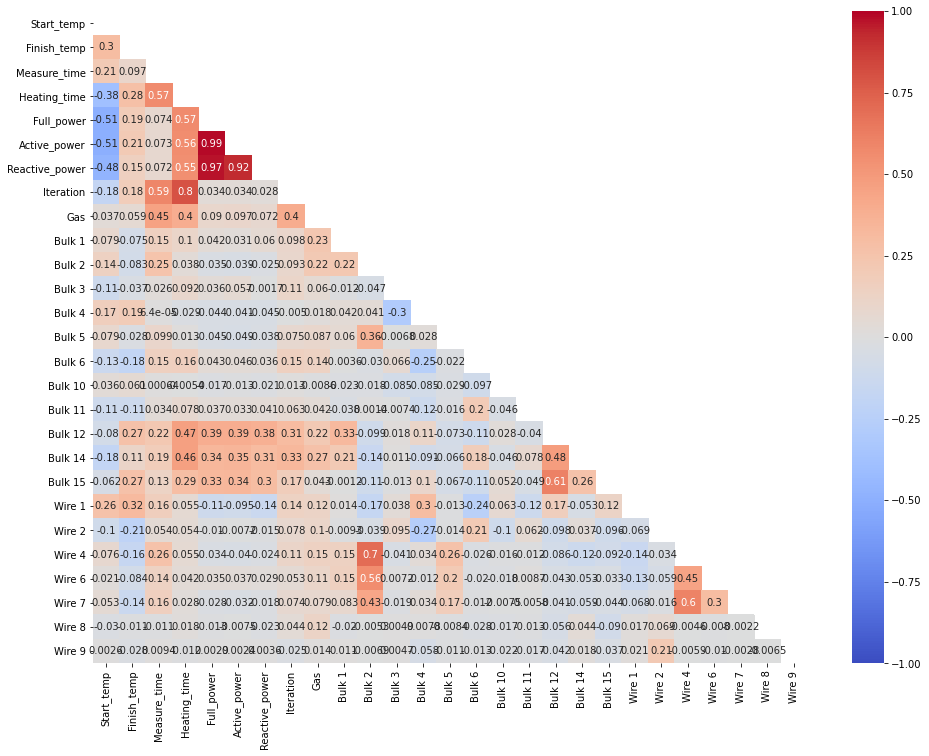

In [50]:
inverted = np.triu(final_table.drop('key', axis=1).corr()) 

fig = plt.subplots(figsize=(16, 12))
sns.heatmap(final_table.drop('key', axis=1).corr(), vmin = -1, vmax = +1, annot = True, cmap = 'coolwarm', 
                mask = inverted)

Между некоторыми сыпучими и проволочными материалами высокая положительная корреляции. Учитывая что с одними компонентами сыпучего материала добавляются одновременно соответсвующие проволочные материалы, то оставим в таблице высококорелирующие компоненты. Также высокая корреляция наблюдается между активной и реактивной мощности, активной и полной мощности, реактивной и полной мощности. Из-за высокой корреляции удалим активную и реактивную мощность. Сильной корреляции между признаками и целевым признаком не наблюдается.

In [51]:
final_table = final_table.drop(['Active_power', 'Reactive_power'], axis=1)

<AxesSubplot:>

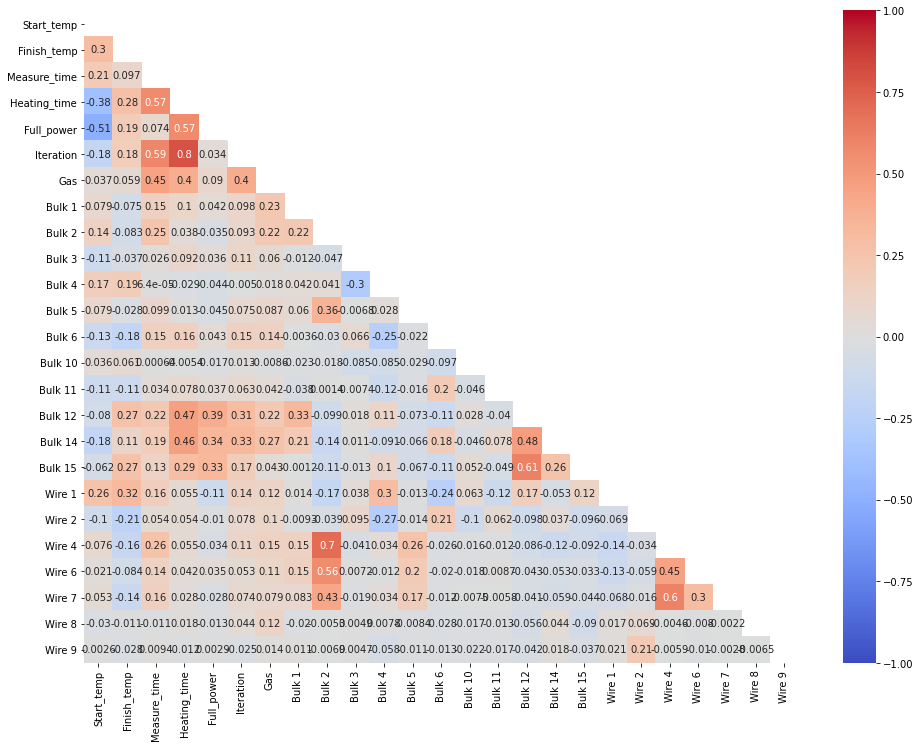

In [52]:
inverted = np.triu(final_table.drop('key', axis=1).corr()) 

fig = plt.subplots(figsize=(16, 12))
sns.heatmap(final_table.drop('key', axis=1).corr(), vmin = -1, vmax = +1, annot = True, cmap = 'coolwarm', 
                mask = inverted)

### Вывод

В результате предобработки данных были удалены отрицательное значение реактивной мощности и значения температур которые ниже температуры плавления стали. В итоговую таблицу помимо имеющихся признаков были добавлены новые. 

## Обучение моделей

### Выбор и обучение моделей

Разделим данные на обучающую и тестовую выборки, поделив их в свою очередь на признаки и целевой признак.

In [53]:
train, test = train_test_split(final_table, test_size=0.25, random_state=RANDOM_STATE)

features_train = train.drop(['key', 'Finish_temp'], axis=1)
target_train = train['Finish_temp']
features_test = test.drop(['key', 'Finish_temp'], axis=1)
target_test = test['Finish_temp']

Используем конвейер Pipeline.

In [54]:
num_pipeline = Pipeline([('std_scaler', StandardScaler())])

In [55]:
features_train_tr = num_pipeline.fit_transform(features_train)

Напишем функцию оценки модели перекрестной проверкой.

In [56]:
def models(model_name):
    model = model_name
    scores = cross_val_score(model,
                            features_train_tr,
                            target_train,
                            scoring='neg_mean_absolute_error', cv=5)
    return (-scores).mean()

Применим функцию к раличным моделям, но для начала посмотрим на оценку случайной модели.

In [57]:
features_test_tr = num_pipeline.transform(features_test)

dummy_regr = DummyRegressor(strategy="mean")
dummy_regr.fit(features_test_tr, target_test)
predict = dummy_regr.predict(features_test_tr)
mean_absolute_error(predict, target_test)

8.140679758621406

Случайная модель показала возможное отклонение в 8 градусов. 

#### LinearRegression

In [58]:
%%time
models(LinearRegression())

CPU times: user 39.4 ms, sys: 47.4 ms, total: 86.7 ms
Wall time: 78.6 ms


5.747073247314925

#### DecisionTreeRegressor

In [59]:
%%time
models(DecisionTreeRegressor(random_state=RANDOM_STATE))

CPU times: user 112 ms, sys: 82.2 ms, total: 194 ms
Wall time: 246 ms


8.549176629450319

#### RandomForestRegressor

In [60]:
%%time
models(RandomForestRegressor(random_state=RANDOM_STATE))

CPU times: user 4.73 s, sys: 1.13 ms, total: 4.73 s
Wall time: 4.74 s


6.103866976253995

#### SVR

In [61]:
%%time
models(SVR(kernel="linear"))

CPU times: user 523 ms, sys: 0 ns, total: 523 ms
Wall time: 529 ms


5.756109905108697

#### KNeighborsRegressor

In [62]:
%%time
models(KNeighborsRegressor())

CPU times: user 172 ms, sys: 309 ms, total: 481 ms
Wall time: 459 ms


6.911334189638708

#### CatBoostRegressor

In [63]:
%%time
models(CatBoostRegressor(random_state=RANDOM_STATE, verbose=False))

CPU times: user 13.4 s, sys: 328 ms, total: 13.8 s
Wall time: 16.6 s


5.678636290516903

#### LGBMRegressor

In [64]:
%%time
models(lgb.LGBMRegressor(random_state=RANDOM_STATE))

CPU times: user 4.85 s, sys: 46.7 ms, total: 4.89 s
Wall time: 4.83 s


5.827380506869057

#### XGBRegressor

In [65]:
%%time
models(xgb.XGBRegressor(random_state=RANDOM_STATE))

CPU times: user 17.3 s, sys: 0 ns, total: 17.3 s
Wall time: 17.3 s


6.208970352171344

Выберем модель с лучшей оченкой для дальнейшей точной настройки. По результатам им оказался **CatBoostRegressor**.

### Точная настройка лучшей модели

#### CatBoostRegressor

In [66]:
%%time
param_distribs = {
        'learning_rate': [0.01, 0.05, 0.1, 0.5, 1],
        'depth': [2, 4, 6, 8, 10],
    }

cat_reg = CatBoostRegressor(random_state=RANDOM_STATE, verbose=False)
cat_search = RandomizedSearchCV(cat_reg, param_distributions=param_distribs,
                                n_iter=10, cv=5, scoring='neg_mean_absolute_error', random_state=RANDOM_STATE)
cat_search.fit(features_train_tr, target_train)

CPU times: user 8min 32s, sys: 3.26 s, total: 8min 35s
Wall time: 9min 6s


RandomizedSearchCV(cv=5,
                   estimator=<catboost.core.CatBoostRegressor object at 0x7f9fef15dd90>,
                   param_distributions={'depth': [2, 4, 6, 8, 10],
                                        'learning_rate': [0.01, 0.05, 0.1, 0.5,
                                                          1]},
                   random_state=80822, scoring='neg_mean_absolute_error')

In [67]:
cat_search.best_params_

{'learning_rate': 0.05, 'depth': 4}

In [68]:
-(cat_search.best_score_)

5.669689587140549

Посмотрим на важные признаки.

In [69]:
feature_importances = cat_search.best_estimator_.feature_importances_

In [70]:
attributes = features_train.columns
sorted(zip(feature_importances, attributes), reverse=True)

[(25.23342807996828, 'Start_temp'),
 (20.104553541837507, 'Heating_time'),
 (8.691729053681629, 'Measure_time'),
 (7.525108161749046, 'Full_power'),
 (5.3536764969200705, 'Wire 1'),
 (5.096701997388447, 'Bulk 6'),
 (4.123501377359465, 'Bulk 14'),
 (3.801541974021049, 'Wire 2'),
 (3.676210435032804, 'Bulk 12'),
 (3.194806356132227, 'Bulk 15'),
 (2.8053811211110555, 'Gas'),
 (2.513775973479178, 'Iteration'),
 (1.9986180542344143, 'Bulk 1'),
 (1.9365006869933754, 'Bulk 4'),
 (1.5196730750408276, 'Bulk 3'),
 (0.5710616436323921, 'Bulk 11'),
 (0.5296707342112221, 'Bulk 2'),
 (0.3506886021592361, 'Bulk 10'),
 (0.3402285734815292, 'Wire 7'),
 (0.2763598344894146, 'Wire 6'),
 (0.20194466260711583, 'Wire 4'),
 (0.08802312691959435, 'Bulk 5'),
 (0.06107712477949729, 'Wire 8'),
 (0.005739312770632537, 'Wire 9')]

### Оценка лучшей модели на тестовой выборке

In [72]:
final_model = cat_search.best_estimator_

final_predictions = final_model.predict(features_test_tr)

final_mae = mean_absolute_error(target_test, final_predictions)
final_mae

5.6532721633227965

## Вывод

Для уменьшения потребления электроэнергии на этапе обработки стали необходимо было построить модель, которая предскажет температуру стали. В ходе выполнения проекта был выполнен анализ данных, предобработка данных и обучение моделей. 

Для достижения необходимых результатов были выбраны следующие модели: LinearRegression, DecisionTreeRegressor, RandomForestRegressor, SVR, KNeighborsRegressor, CatBoostRegressor, LGBMRegressor, XGBRegressor. Кросс-валидацией на "скорую руку" проверили качество предсказаний моделей. Для точной настройки гиперпараметров былf выбранf моделm **CatBoostRegressor** показавшая лучший результат точности. Для подбора гиперпараметров использовали RandomizedSearchCV. Также на этапе настройки гиперпараметров проверили важные признаки для модели **CatBoostRegressor**, ими оказались: замер начальной температуры сплава, время нагрева и общее время измерения темпереатуры. При проверке **CatBoostRegressor** на тестовой выборке значение MAE получили 5.65, что соответсвует условию MAE < 6. 